## Import main functions

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/l4_dataset')

In [3]:
import numpy as np

import tensorflow.keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model, Sequential
import umap

In [0]:
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, PReLU
from tensorflow.keras.layers import Dense

In [0]:
import os, copy
%matplotlib inline

imw = 192
imh = 192
c = 3
RS = 2211

In [0]:
import seaborn as sns
import matplotlib.patheffects as PathEffects

In [0]:
from sklearn.manifold import TSNE
import umap
import cv2 

In [8]:
encoder = load_model("/content/gdrive/My Drive/l4_dataset/encoder_balanced_weights.h5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 192, 64)      1792      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 192, 192, 64)      2359296   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 96, 96, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        18464     
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 96, 96, 32)        294912    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 32)        0   

In [0]:
classifier = Sequential()
classifier.add(encoder)
classifier.add(Dense(128, activation='relu'))
classifier.add(Dense(1, activation='linear'))

In [10]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 2304)              2764368   
_________________________________________________________________
dense (Dense)                (None, 128)               295040    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 3,059,537
Trainable params: 3,059,537
Non-trainable params: 0
_________________________________________________________________


In [0]:
classifier.compile(loss='mean_squared_error',
              optimizer='adam')

## Helper functions

In [0]:
def low_clip(x):
    x[x<=255] = 0
    return x

def minmax(x):
    if x.min() == x.max():
        return x
    return (x-x.min())/(x.max()-x.min())

def is_faulty(x):
  if x.max() <= 255:
    return True
  return False

In [0]:
def get_label(filename):
    # 0: unstimulated
    # 1: OVA
    # 2: ConA
    # 3: empty/faulty

    # filename format: folder/CKX - L - 00(...)
    file = filename.split("/")[-1].split("(")[0]

    # get letter for DMSO indices
    letter = file.split('-')[1].strip()

    # get number
    number = file[-2:].strip()

    # get plate layout number
    ck = file[:4]

    # DMSO = []

    if ck == "CK19":
        #if number in ["5", "8", "11", "15", "18", "21"] and letter in ["N", "O", "P"]:
        #   DMSO.append(len(labels))
        if number in ["3", "4", "5", "6", "7", "8", "24"]:
            label = 0
        elif number in ["9", "10", "11", "13", "14", "15", "23"]:
            label = 1
        elif number in ["16", "17", "18", "19", "20", "21", "22"]:
            label = 2
        else:
            label = 3
    elif ck == "CK21" or ck == "CK22":
        if number in ["02", "03", "04", "05", "06", "07", "08", "09", "10", "11"]:
            label = 0
        elif int(number) in range(14, 24):
            label = 2
        else:
            label = 3
        #if label != 3 and letter in ["H", "P"]:
        #    DMSO.append(len(labels))
    else:
        print("No CK found")
        return False

    return label
  
def unishuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [0]:
def show_image(img, title="untitled", cmap="gray", **kwargs):
    try:
        plt.imshow(img, cmap=cmap, **kwargs)
    except:
        plt.imshow(img[:, :, 0], cmap=cmap, **kwargs)
    plt.axis("off")
    plt.title(title)

def reshape(img, w=imw, h=imh, c=c):
    if c > 1:
      return np.reshape(img, (w, h, c))
    else:
      return np.reshape(img, (w, h))

In [0]:
def convert_to_binary(a):
    val = np.unique(a)[1]
    above_threshold = a >= val
    under_threshold = a < val
    a[above_threshold] = 1
    a[under_threshold] = 0
    return a.astype(np.uint8).reshape(int(np.sqrt(len(a))), int(np.sqrt(len(a))))

# For 500 images:
# CPU times: user 21 s, sys: 37.7 ms, total: 21 s
# Wall time: 5.49 s
def get_mask(img):
    # if image is all black: ignore
    if not img.any():
        return img.astype(np.uint8)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _,label,center = cv2.kmeans(img.reshape(np.prod(img.shape), 1), 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    return convert_to_binary(center[label])

# For 500 images
# CPU times: user 180 ms, sys: 2 µs, total: 180 ms
# Wall time: 181 ms
def threshold(x):
    mask = np.copy(x)
    mask = mask.ravel()
    above_threshold = mask > x.mean()+x.std()
    under_threshold = mask <= x.mean() + x.std()
    mask[above_threshold] = 1
    mask[under_threshold] = 0
    return mask.astype(np.uint8).reshape((x.shape))

# intersection over union (evaluation function)
def iou(a,b):
    a = a.astype(np.bool)
    b = b.astype(np.bool)
    i = a*b
    u = a+b
    if u.sum() == 0:
        return 0
    return i.sum()/(a.sum()+b.sum())

In [0]:
def plot_range(imgs, rn=8):
  fig = plt.figure(figsize=(15, 15))
  for i in range(1, 6):
    ax = fig.add_subplot(1, 5, i)
    plt.imshow(imgs[i+rn])
    ax.axis('off')

## Read data

In [0]:
npzfile = np.load('/content/gdrive/My Drive/l4_dataset/CK19_full.npz')

In [0]:
metrics = np.load('/content/gdrive/My Drive/l4_dataset/CK19_calculated_metrics.npz')

In [0]:
filenames = npzfile['y']

In [0]:
y = np.array([get_label(i) for i in filenames])

In [0]:
X = npzfile['x']

In [0]:
calculated = metrics['calculated']

## Process images into dataset

In [0]:
def preprocess_with_overlap(data, labels, mask=False):
    data = np.copy(data)
    l = len(data)
    # initialise arrays for filling in
    x_data = np.ndarray(shape=(l // 2, 192, 192, 3), dtype=np.float32)
    y_data = np.ndarray(shape=(l // 2), dtype=np.uint8)

    # initialise index values
    idx = 0
    i = 0
    count = 0

    # loop through images and process
    while idx < l-100:
        # ignore 100, 300, etc. values as they will already have been processed
        if count == 100:
            # print('---new image---')
            count = 0
            idx += 100
        else:
           # print('-- image {} ---\n'
           #       'channel 1: {}\n'
           #       'channel 0: {}\n'
           #       'count: {}\n'.format(i, idx, idx+100, count))

            # if the image is "faulty" we cannot low_clip and apply minmax -> NaN
            if is_faulty(data[idx]) or is_faulty(data[idx + 100]):
                x_data[i, ..., 1] = minmax(data[idx])
                x_data[i, ..., 0] = minmax(data[idx + 100])
            else:
                x_data[i, ..., 1] = minmax(low_clip(data[idx]))
                x_data[i, ..., 0] = minmax(low_clip(data[idx + 100]))
            
            y_data[i] = labels[i]

            # mask out the background
            if mask:
                x_data[i, ..., 0] *= get_mask(x_data[i, ..., 0])  # red-coloured
                x_data[i, ..., 1] *= get_mask(x_data[i, ..., 1])  # green-coloured

            # try and save memory
            data[idx] = 0
            data[idx+100] = 0

            idx += 1
            i += 1
            count += 1

    print('Images preprocessed. Size of dataset: {}'.format(len(x_data)))
    return x_data, y_data

In [28]:
x_combined, y_combined = preprocess_with_overlap(X, calculated)

Images preprocessed. Size of dataset: 29400


In [0]:
X = None

In [0]:
x_masked, y_masked = preprocess(X, y_dmso, mask=True)       

Images preprocessed. Size of dataset: 9800


In [0]:
X = None

In [0]:
x_train, y_train = unishuffle(x_masked, y_masked)

In [0]:
x_masked, y_masked = None, None

In [0]:
x_train, y_train = unishuffle(x_combined, y_combined[:15000])

In [0]:
x_combined, y_combined = None, None

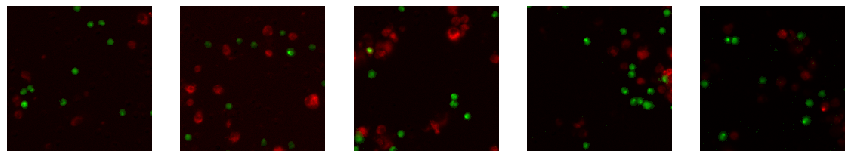

In [30]:
plot_range(x_combined, rn=5739)

## Interaction classifier (quantity)

In [0]:
x_train, x_test, y_train, y_test = x_combined[:-5000], x_combined[-5000:], calculated[:-5000], calculated[-5000:]

In [32]:
len(x_train), len(x_test)

(24400, 5000)

In [60]:
history = classifier.fit(x_train, y_train,
          batch_size=64,
          epochs=10,
          verbose=1,
          validation_split=0.15)

Train on 20740 samples, validate on 3660 samples
Epoch 1/15
20740/20740 [==============================] - 37s 2ms/sample - loss: 0.0015 - val_loss: 0.0018
Epoch 2/15
20740/20740 [==============================] - 37s 2ms/sample - loss: 0.0014 - val_loss: 0.0015
Epoch 3/15
20740/20740 [==============================] - 37s 2ms/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 4/15
20740/20740 [==============================] - 37s 2ms/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 5/15
20740/20740 [==============================] - 37s 2ms/sample - loss: 0.0010 - val_loss: 0.0011
Epoch 6/15
20740/20740 [==============================] - 37s 2ms/sample - loss: 7.6601e-04 - val_loss: 0.0011
Epoch 7/15
20740/20740 [==============================] - 37s 2ms/sample - loss: 6.0088e-04 - val_loss: 8.9499e-04
Epoch 8/15
20740/20740 [==============================] - 37s 2ms/sample - loss: 3.9660e-04 - val_loss: 9.3470e-04
Epoch 9/15
20740/20740 [==============================] - 37s 2ms/sample - 

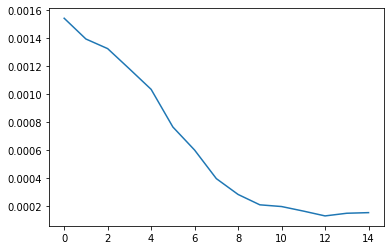

In [61]:
plt.plot(history.history['loss'])

In [41]:
score1 = classifier.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Test loss: 5.771695586481717e-09
Test accuracy: 5.7716965e-09


In [0]:
predictions = classifier.predict(x_test)

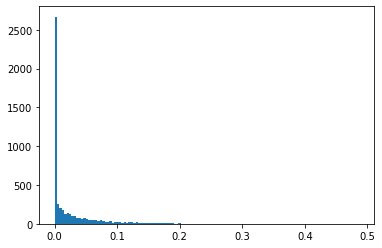

In [64]:
plt.hist(y_test, bins=128)
plt.show()

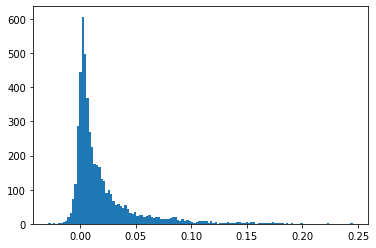

In [63]:
plt.hist(predictions, bins=128)
plt.show()

In [0]:
labels = metrics['labels']

In [0]:
unstimulated = calculated[labels==0]
ova = calculated[labels==1]
cona = calculated[labels==2]
faulty = calculated[labels==3]

In [0]:
palette = np.array(sns.color_palette("hls", 4))

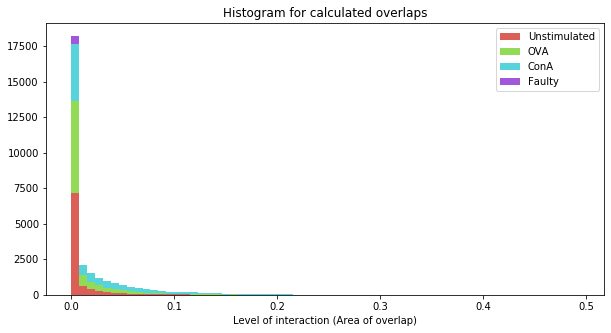

In [69]:
plt.figure(figsize=(10,5))
plt.hist([unstimulated.flatten(), ova.flatten(), cona.flatten(), faulty.flatten()], bins=64, histtype="barstacked", 
         label=["Unstimulated", "OVA", "ConA", "Faulty"],
         color=palette)
plt.title("Histogram for calculated overlaps")
plt.legend()
plt.xlabel("Level of interaction (Area of overlap)")
plt.show()

In [0]:
labels_test = labels[-5000:]

In [0]:
unstimulated = predictions[labels_test==0]
ova = predictions[labels_test==1]
cona = predictions[labels_test==2]
faulty = predictions[labels_test==3]

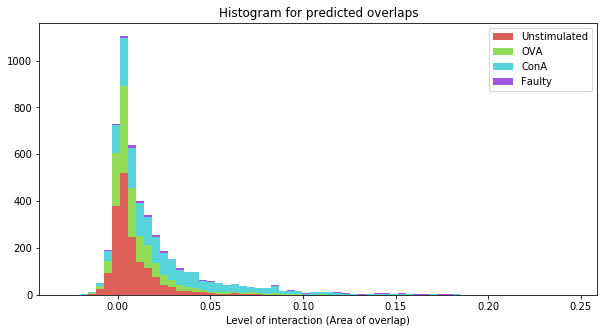

In [75]:
plt.figure(figsize=(10,5))
plt.hist([unstimulated.flatten(), ova.flatten(), cona.flatten(), faulty.flatten()], bins=64, histtype="barstacked", 
         label=["Unstimulated", "OVA", "ConA", "Faulty"],
         color=palette)
plt.title("Histogram for predicted overlaps")
plt.legend()
plt.xlabel("Level of interaction (Area of overlap)")
plt.show()

In [0]:
predictions[predictions < 0] = 0

In [0]:
unstimulated = predictions[labels_test==0]
ova = predictions[labels_test==1]
cona = predictions[labels_test==2]
faulty = predictions[labels_test==3]

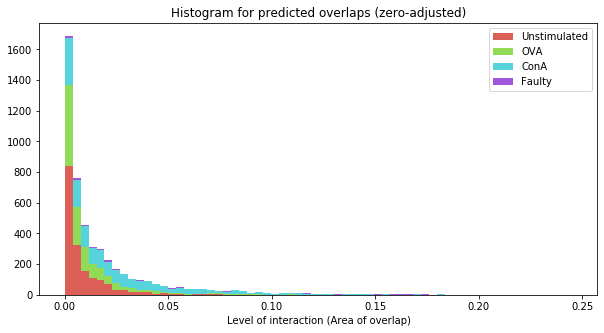

In [78]:
plt.figure(figsize=(10,5))
plt.hist([unstimulated.flatten(), ova.flatten(), cona.flatten(), faulty.flatten()], bins=64, histtype="barstacked", 
         label=["Unstimulated", "OVA", "ConA", "Faulty"],
         color=palette)
plt.title("Histogram for predicted overlaps (zero-adjusted)")
plt.legend()
plt.xlabel("Level of interaction (Area of overlap)")
plt.show()

In [0]:
unstimulated = [np.sum(unstimulated[current: current+100]) for current in range(0, len(unstimulated), 100)]
ova = [np.sum(ova[current: current+100]) for current in range(0, len(ova), 100)]
cona = [np.sum(cona[current: current+100]) for current in range(0, len(cona), 100)]

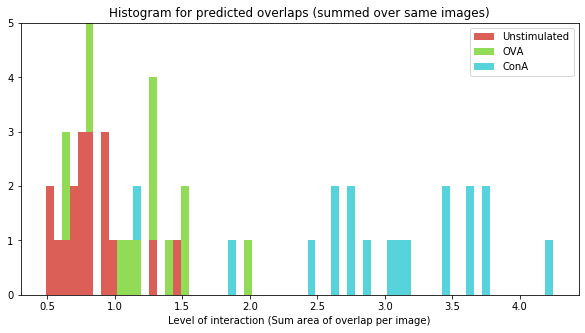

In [81]:
plt.figure(figsize=(10,5))
plt.hist([unstimulated, ova, cona], bins=64, histtype="barstacked", 
         label=["Unstimulated", "OVA", "ConA"],
        color=palette[:3])
plt.title("Histogram for predicted overlaps (summed over same images)")
plt.legend()
plt.xlabel("Level of interaction (Sum area of overlap per image)")
plt.show()

## Label classifier (unstimulated, ova, cona, faulty)

```python
classifier = Sequential()
classifier.add(encoder)
classifier.add(Dense(128, activation='relu'))
classifier.add(Dense(4, activation='softmax'))
```

In [0]:
x_train, x_test, y_train, y_test = x_combined[:-1000], x_combined[-1000:], y_combined[:-1000], y_combined[-1000:]

In [0]:
len(x_train), len(x_test)

(27600, 1000)

In [0]:
y_train_c = tensorflow.keras.utils.to_categorical(y_train, 4)

In [0]:
y_test_c = tensorflow.keras.utils.to_categorical(y_test, 4)

In [0]:
history = classifier.fit(x_train, y_train_c,
          batch_size=64,
          epochs=10,
          verbose=1,
          validation_split=0.15)

Train on 23460 samples, validate on 4140 samples
Epoch 1/10
23460/23460 [==============================] - 45s 2ms/sample - loss: 0.9583 - acc: 0.5219 - val_loss: 0.9563 - val_acc: 0.5435
Epoch 2/10
23460/23460 [==============================] - 42s 2ms/sample - loss: 0.8078 - acc: 0.6246 - val_loss: 0.8666 - val_acc: 0.5966
Epoch 3/10
23460/23460 [==============================] - 42s 2ms/sample - loss: 0.7386 - acc: 0.6659 - val_loss: 0.9142 - val_acc: 0.5865
Epoch 4/10
23460/23460 [==============================] - 42s 2ms/sample - loss: 0.6689 - acc: 0.7057 - val_loss: 0.9046 - val_acc: 0.5937
Epoch 5/10
23460/23460 [==============================] - 42s 2ms/sample - loss: 0.6012 - acc: 0.7447 - val_loss: 0.9511 - val_acc: 0.5845
Epoch 6/10
23460/23460 [==============================] - 42s 2ms/sample - loss: 0.4663 - acc: 0.8087 - val_loss: 1.0370 - val_acc: 0.5906
Epoch 7/10
23460/23460 [==============================] - 42s 2ms/sample - loss: 0.3313 - acc: 0.8766 - val_loss: 1.2

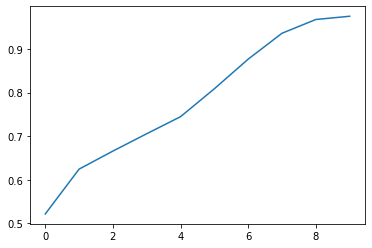

In [0]:
plt.plot(history.history['acc'])

In [0]:
score1 = classifier.evaluate(x_test, y_test_c, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Test loss: 2.2097943849563597
Test accuracy: 0.528


In [0]:
y_pred = np.argmax(classifier.predict(x_test), axis=1)

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

names = ["Unstimulated", "OVA", "ConA", "Faulty"]

def plot_confusion_matrix(predictions, labels):
  plt.figure(figsize=(12,10))
  cm = confusion_matrix(labels, predictions)
  ax = sn.heatmap(cm, fmt="d", annot=True, cmap="Greens", cbar_kws={'label': 'Number of predictions'}, 
             xticklabels=names, yticklabels=names)
  ax.set_ylabel("True label")
  ax.set_xlabel("Predicted label")

In [0]:
np.sum(y_test[y_test==1])

21.0

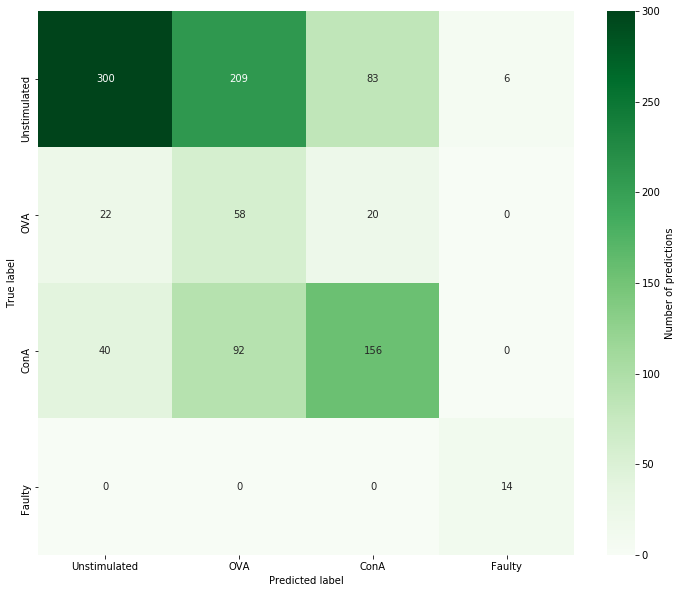

In [0]:
plot_confusion_matrix(y_pred, y_test)